# EPM Moderators of Aging - PBB Case Study

## Notebook Setup

In [1]:
import bisect
from collections import defaultdict, Counter
import math
import pkg_resources
from typing import Dict, List, Set, Tuple, Union
import sys
import warnings

from EpigeneticPacemaker.EpigeneticPacemaker import EpigeneticPacemaker
from EpigeneticPacemaker.EpigeneticPacemakerCV import EpigeneticPacemakerCV
from EPMTrait.DataHandlers import retrieve_sample_methylation, get_normalization_ref
from EPMTrait.QuantileNormalization import QuantileNormalizeSample
from EPMTrait.ModelHelpers import basic_func, fit_trend, get_age_bins, mae, pearson_correlation, r2
from EPMTrait.Plots import plot_known_predicted

import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import pandas as pd
from patsy import dmatrices
import pickle
from scipy import optimize
import scipy.stats as stats
import seaborn as sns
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm.notebook import tqdm

### Get Session Environment Information
- notebook environment 
    - Python 3.8.0 (default, Dec  5 2019, 19:17:49) [GCC 9.2.1 20191008]
    - EPMTrait 0.0.1
    - EpigeneticPacemaker 0.0.3
    - backcall 0.2.0
    - cffi 1.14.0
    - colorama 0.4.3
    - cycler 0.10.0
    - decorator 4.4.1
    - ipykernel 5.3.0
    - ipywidgets 7.6.3
    - jedi 0.17.2
    - joblib 1.0.1
    - kiwisolver 1.1.0
    - matplotlib 3.4.3
    - numexpr 2.7.1
    - numpy 1.21.1
    - pandas 1.3.1
    - parso 0.7.0
    - patsy 0.5.1
    - pexpect 4.7.0
    - pickleshare 0.7.5
    - psutil 5.7.0
    - ptyprocess 0.6.0
    - pyparsing 2.4.5
    - pytz 2019.3
    - scikit-learn 0.24.2
    - scipy 1.4.1
    - seaborn 0.11.1
    - simplejson 3.17.0
    - six 1.15.0
    - statsmodels 0.11.1
    - threadpoolctl 2.1.0
    - tornado 6.1
    - tqdm 4.62.2
    - traitlets 4.3.3
    - wcwidth 0.2.4

In [2]:
def get_session_info(import_diff_modules=[]):
    '''
    Retrieve python version and list of imported packages that 
    are imported directly or as dependencies:
        Args:
            import_diff_modules (List[str]): list of modules that have different install and 
                                        import names, ie scikit-learn imported with sklearn
        Returns:
            Dict[str, str]: package_name : version 
    '''
    local_pkgs = {str(i).split()[0]:str(i).split()[1] for i in pkg_resources.working_set}
    session_pkgs = {'Python':sys.version}
    for pkg in sorted(list(set([x.split('.')[0] for x in sys.modules])) + import_diff_modules):
        if pkg in local_pkgs:
            session_pkgs[pkg] = local_pkgs[pkg]
    return session_pkgs

In [3]:
# collect session info
session_info = get_session_info(import_diff_modules=['scikit-learn'])

In [4]:
# filter warnings associated scipy.optimize trend fitting
warnings.filterwarnings("ignore", message="Covariance of the parameters could not be estimated")

### Set Plot Characteristics

In [5]:
sns.set(palette="Paired", style='white')
plt.rcParams['legend.title_fontsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.markerscale'] = 2
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['text.usetex'] = False

### Import Reference Data

In [6]:
wd = '/media/colin/Linux_Data/EPMTraitAssociation/'
sample_meta_file = f'processed_sample_meta.pkl'

In [7]:
with open(sample_meta_file, 'rb') as meta:
    sample_meta = pickle.load(meta)

In [8]:
case_study_exp = {'GSE116339'}

In [9]:
cs_meta = {sample_id: sample_info for sample_id, sample_info in sample_meta.items() if sample_info['experiment_id'] in case_study_exp}

In [10]:
Counter([info['experiment_id'] for info in cs_meta.values()]), len(cs_meta)

(Counter({'GSE116339': 679}), 679)

### Train test split

In [11]:
ref_ages = np.array([sample['age yrs'] for sample in cs_meta.values()])

In [12]:
min(ref_ages), max(ref_ages)

(23.0, 88.46)

In [13]:
len(ref_ages)

679

In [14]:
ref_sex = np.array([sample['proc_predictedSex'] for sample in cs_meta.values()])
ref_sex = np.array([1 if sex == 'F' else 0 for sex in ref_sex])

In [15]:
ref_exps = np.array([sample['experiment_id'] for sample in cs_meta.values()])

In [16]:
cs_samples = list(cs_meta.keys())

In [17]:
cell_types = ['proc_CD8T', 'proc_CD4T', 'proc_NK',
              'proc_Bcell','proc_Mono', 'proc_Gran']

In [18]:
ref_cells = []

for ct in cell_types:
    ref_cells.append([sample[ct] for sample in cs_meta.values()])

In [19]:
cell_pca = PCA(whiten=False).fit(np.array(ref_cells).T)
cell_pcs = cell_pca.transform(np.array(ref_cells).T)

In [20]:
ref_cells = pd.DataFrame(ref_cells, columns=cs_meta.keys(), index=cell_types).T

In [21]:
ref_cells['Age'] = ref_ages

In [22]:
def merge_bins(bins, min_bin_size=5):
    merged_bins = list(bins)
    while True:
        max_bin = max(merged_bins) - 1
        cleaned_bins = []
        bin_count = Counter(merged_bins)
        all_bins_merged = True
        for sample_bin in merged_bins:
            if bin_count[sample_bin] < min_bin_size:
                all_bins_merged = False
                if sample_bin < max_bin:
                    cleaned_bins.append(sample_bin + 1)
                else:
                    cleaned_bins.append(sample_bin - 1)
            else:
                cleaned_bins.append(sample_bin)
        merged_bins = cleaned_bins
        if all_bins_merged:
            break
    return np.array(merged_bins)       

In [23]:
def get_age_bins(ages, bin_number=20):
    binning = []
    interval = (max(ages) - min(ages)) / bin_number
    bin_ranges = [interval * x for x in range(bin_number)]
    for age in ages:
        binning.append(bisect.bisect_left(bin_ranges, age))
    return merge_bins(binning)

In [24]:
age_bins = get_age_bins(ref_ages, bin_number=20)

In [25]:
train_indices, test_indices = train_test_split([x for x in range(len(cs_meta))], stratify=age_bins, 
                                               test_size=.5, random_state=1)

In [26]:
test_indices = [x for x in range(len(cs_meta)) if x not in train_indices]

In [27]:
len(train_indices)

339

In [28]:
train_sex, test_sex = ref_sex[train_indices], ref_sex[test_indices]

In [29]:
train_samples, test_samples = np.array(cs_samples)[train_indices], np.array(cs_samples)[test_indices]

In [30]:
Counter([cs_meta[sample]['experiment_id'] for sample in train_samples])

Counter({'GSE116339': 339})

In [31]:
train_ages, test_ages = ref_ages[train_indices], ref_ages[test_indices]

In [32]:
train_cells, test_cells = ref_cells.loc[train_samples], ref_cells.loc[test_samples]

### Load Training Data

In [33]:
def get_sample_matrix_info(sample_meta):
    sample_name = '_'.join(sample_meta["Grn"].split('_')[0:-1])
    file_prefix = f'{sample_meta["experiment_id"]}_{sample_meta["batch"]}'
    return f'\"{sample_name}\"', file_prefix

In [34]:
processing_dir = f'{wd}processed_data/'

In [35]:
train_files = [get_sample_matrix_info(cs_meta[sample]) for sample in train_samples]
train_files = {sample[0]: f'{processing_dir}{sample[1]}_methmatrix.gz' for sample in train_files}

In [36]:
train_methylation, train_header, train_rows = retrieve_sample_methylation(train_files, n_jobs=16, verbosity=10)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of   5 | elapsed:   41.3s remaining:  1.0min
[Parallel(n_jobs=16)]: Done   3 out of   5 | elapsed:   41.9s remaining:   27.9s
[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:   43.1s remaining:    0.0s
[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:   43.1s finished


In [37]:
cleaned_train_header = [x.replace('"', '').split('_')[0] for x in train_header][1:]

In [38]:
train_matrix =  pd.DataFrame(train_methylation, columns=cleaned_train_header, index=train_rows)

In [39]:
train_ages = np.array([cs_meta[sample]['age yrs'] for sample in list(train_matrix)])

In [40]:
sample_exps = [sample_meta[sample]['experiment_id'] for sample in list(train_matrix)]

In [41]:
train_sex = np.array([cs_meta[sample]['proc_predictedSex'] for sample in list(train_matrix)])
train_sex = np.array([1 if sex == 'F' else 0 for sex in train_sex])

In [42]:
train_cells = train_cells.loc[list(train_matrix)]

### Fit Age LM 

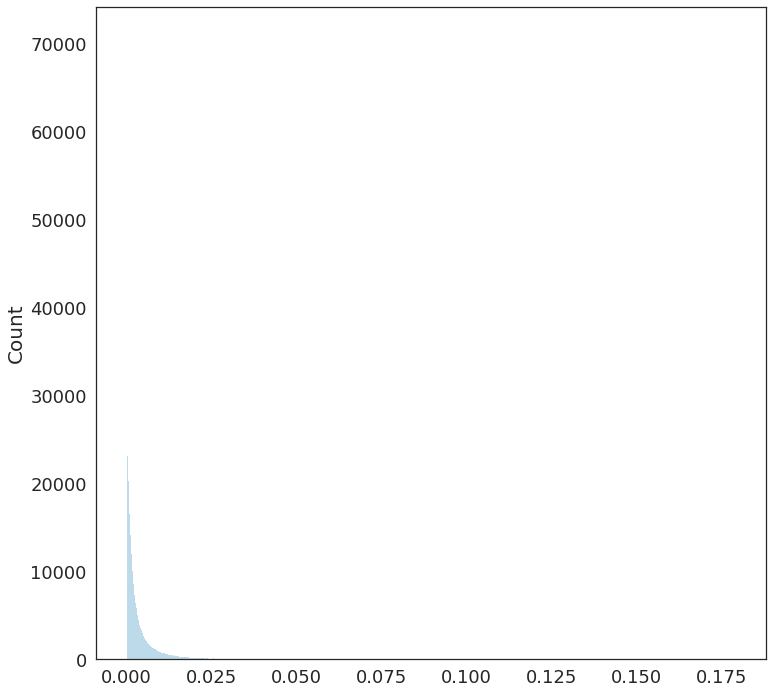

In [43]:
fig, ax = plt.subplots(figsize=(12,12))

sns.histplot(train_matrix.var(axis=1).values, ax=ax)

plt.show()

In [44]:
lm_sites = [site[0] for site in (train_matrix.var(axis=1) > 0.001).to_dict().items() if site[1]]

In [45]:
def lin_func(x, a, b, c):
    return a * np.asarray(x) + c

In [46]:
def plot_lm(popt, ax, label='', hue=None, style=None, ages=None, eas=None):
    lm_r2 = r2(lin_func(ages, *popt), eas)
    fit_label = f'{label}  $f(x) = {popt[0]: .3f}x + {popt[2]: .3f}, R^2={lm_r2: .3f}$'
    sns.scatterplot(x=ages, y=eas, ax=ax, hue=hue, style=style)
    age_range = np.linspace(min(ages), max(ages), 100)
    expected_range = lin_func(age_range, *popt)
    ax.plot(age_range, expected_range, 'k--', lw=2, label=fit_label)
    ax.legend(fontsize=18, loc='upper left', frameon=False)
    ax.set_xlabel('Chronological Age (y)')
    ax.set_ylabel('Epigenetic Age (y)')
    return ax

In [47]:
def fit_lm(values, ages, en_kwargs):
    lm = ElasticNetCV(**en_kwargs)
    lm.fit(values.T, ages)
    predicted = lm.predict(values.T)
    return lm, predicted

In [48]:
def sparsify_lm(lm):
    sites = np.array([count for count, coef in enumerate(lm.coef_) if coef])
    model_coefs = lm.coef_[sites]
    intercept = lm.intercept_
    return sites, model_coefs, intercept

In [49]:
def get_sparse_model_predictions(values, sparse_lm):
    model_coefs, intercept = sparse_lm[1], sparse_lm[2]
    return np.dot(model_coefs, values) + intercept

In [50]:
default_en_kwargs = dict(alphas=None, l1_ratio=0.75, fit_intercept=True, cv=3,
                         normalize=False, precompute=False, max_iter=500, copy_X=True, 
                         tol=0.0001, positive=False, random_state=None, selection='random', n_jobs=16,
                         verbose=1)

In [51]:
full_age_lm = fit_lm(train_matrix.loc[lm_sites].values, train_ages, default_en_kwargs)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=16)]: Done   3 out of   3 | elapsed:  6.4min finished


In [52]:
sparse_full_lm = sparsify_lm(full_age_lm[0])

In [53]:
lm_labels = [lm_sites[count] for count, coef in enumerate(full_age_lm[0].coef_) if coef]

In [54]:
train_lm_predictions = get_sparse_model_predictions(train_matrix.loc[lm_labels].values, sparse_full_lm) 

In [55]:
full_lm_popt, _, _ = fit_trend(train_ages, train_lm_predictions, func=lin_func)

<AxesSubplot:xlabel='Chronological Age (y)', ylabel='Epigenetic Age (y)'>

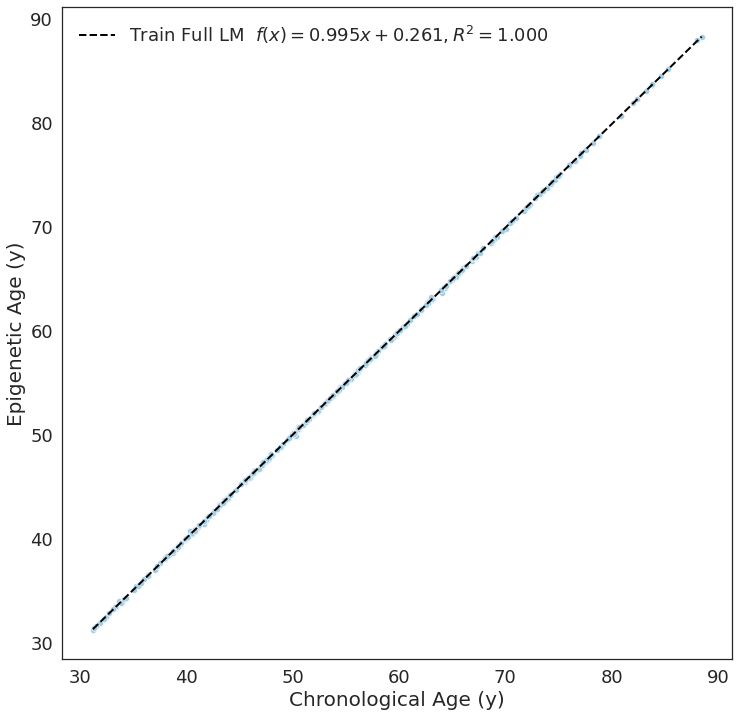

In [56]:
fig, ax = plt.subplots(figsize=(12,12))

plot_lm(full_lm_popt, ax, label='Train Full LM', ages=train_ages, eas=train_lm_predictions)

## EPM Fitting

### Subset Age Associated Sites

In [57]:
age_sites = np.where(abs(pearson_correlation(train_matrix.values, train_ages)) > .4)[0]

In [58]:
len(age_sites)

2418

### Subset Age / Sex Sites

In [59]:
age_site_labels = [train_matrix.index[index] for index in age_sites]

In [60]:
epm_matrix = train_matrix.loc[age_site_labels]

### Site Characterization 

In [61]:
def get_expected(values, coefs):
    return np.sum([values * coef for coef in coefs[:-1]], axis=0) + coefs[-1]

In [62]:
def get_ss_state(expected_meth_values, coefs):
    '''Only work with 1st degree linear model'''
    return (expected_meth_values - coefs[1]) / coefs[0]

In [63]:
def fit_linear_model(meth_values, ages, degrees=1, label=None):
    coefs = np.polyfit(ages, meth_values, degrees)
    predicted_meth = get_expected(ages, coefs)
    r = stats.pearsonr(predicted_meth, meth_values)[0]
    mae = np.mean(abs(predicted_meth - meth_values))
    std = np.std(abs(predicted_meth - meth_values))
    fit_label = label if label else degrees
    return {f'{fit_label}r':r, f'{fit_label}mae': mae, 
            f'{fit_label}coefs': coefs, 
            f'{fit_label}predicted_meth': predicted_meth,
            f'{fit_label}std': std}

In [64]:
def characterize_site(meth_values, ages, trait=np.array([]), linear_fits=2):
    site_info = {}
    site_info['range'] = max(meth_values) - min(meth_values)
    site_info['mean'] = np.mean(meth_values)
    site_info['variance'] = np.var(meth_values)
    site_info['std'] = np.std(meth_values)
    site_info['r'] = stats.pearsonr(meth_values, ages)[0]
    if len(trait) > 1:
        site_info['trait_r'] = stats.pearsonr(meth_values, trait)[0]
    for model in range(linear_fits):
        results = fit_linear_model(meth_values, ages, model + 1)
        site_info.update(results)
        if model + 1 == 1:
            states = get_ss_state(results['1predicted_meth'], results['1coefs'])
            ss_results = fit_linear_model(meth_values, states, 1, '1ss')
            site_info['1states'] = states
    return site_info

In [65]:
def get_fit_label(coefs):
    model_parts = [f'{coef:.5f}' for coef in coefs[::-1]]
    cleaned_model = [model_parts[0], f'{model_parts[1]}x']
    if len(model_parts) > 2:
        for count, part in enumerate(model_parts[2:]):
            cleaned_model.append(f'{part}x^{count + 2}')
    return f'f(x) = {"+".join(cleaned_model)}'

In [66]:
def plot_site(meth_values, ages, coefs, mae, ax, color='k'):
    fit_label = get_fit_label(coefs)
    plot_ages = np.linspace(min(ages), max(ages), 1000)
    ax.plot(plot_ages, get_expected(plot_ages, coefs), f'{color}--', label=f'${fit_label},MAE={mae: .4f}$')
    ax.scatter(ages, meth_values, marker='o', alpha=0.8, color=color)
    ax.set_xlabel('Age')
    ax.set_ylabel('beta')
    ax.legend()

### Modeling Site Variation
- samples with no age acceleration should show primarily technical variation 
- sample with age acceleration should have a mix of technical and biological variation 
- $\hat{m_i} = m_i^0 + r_js_{i} + \epsilon_{i,j}$
    - $\epsilon_{i,j} = \epsilon_{b,i,j} + \epsilon_{t,i,j}$
    - minimize shared $\epsilon_{b,i,j}$

In [67]:
sites_info = {}

for count, site in tqdm(enumerate(epm_matrix.values)):
    sites_info[count] = characterize_site(site, train_ages, train_sex, linear_fits=1)

0it [00:00, ?it/s]

In [68]:
## calculate average deviation from trend

sample_error = []
epm_sites = []

for site, site_info in sites_info.items():
    if site_info['1mae'] > .035:
        continue
    epm_sites.append(epm_matrix.index[site])
    meth_values = epm_matrix.values[site, :]
    predicted_meth = site_info['1predicted_meth']
    direction = 1 if site_info['1coefs'][1] > 0 else -1 
    direction = 1
    sample_error.append((meth_values - predicted_meth) * direction)
    
sample_error = np.array(sample_error)

In [69]:
len(sites_info)

2418

In [70]:
len(epm_sites)

1230

In [71]:
epm_matrix = epm_matrix.loc[epm_sites]

### Cluster Similar Sites
- simulate *phenotypes* based on shared variation amongst similar sites 

In [72]:
def ap_cluster_meth_sites(site_values, cluster_preference=5):
    af = AffinityPropagation(preference=cluster_preference, random_state=1)
    af.fit(site_values)
    labels = defaultdict(list)
    for site_index, site_label in enumerate(af.labels_):
        labels[site_label].append(site_index)
    return af, labels, {count:center for count, center in enumerate(af.cluster_centers_indices_)}

In [73]:
cluster_fit, site_labels, cluster_centers = ap_cluster_meth_sites(sample_error, cluster_preference=-2.5)

In [74]:
def get_site_pcs(site_values):
    pca = PCA(whiten=False, n_components=10)
    pcs = pca.fit_transform(site_values)
    return pcs, pca.explained_variance_ratio_

In [75]:
def plot_af_cluster(x, y, site_labels, cluster_centers, ax=None, size_filter=0):
    for cluster_label, cluster_center in tqdm(cluster_centers.items()):
        cluster_sites = site_labels[cluster_label]
        if len(cluster_sites) < size_filter:
            continue
        color = list(np.random.rand(3,))
        center_x, center_y = x[cluster_center], y[cluster_center]
        cluster_x, cluster_y = x[cluster_sites], y[cluster_sites]
        ax.scatter(x=cluster_x, y=cluster_y, 
                   color=color, alpha=.5)
        ax.scatter(x=center_x, y=center_y,
                   s=200, color=color, alpha=.7)
        for site_x, site_y in zip(cluster_x, cluster_y):
            ax.plot([site_x, center_x], [site_y, center_y], color=color, lw=2, alpha=.3)
    return ax

In [76]:
train_pcs, train_pcs_var = get_site_pcs(sample_error)

  0%|          | 0/10 [00:00<?, ?it/s]

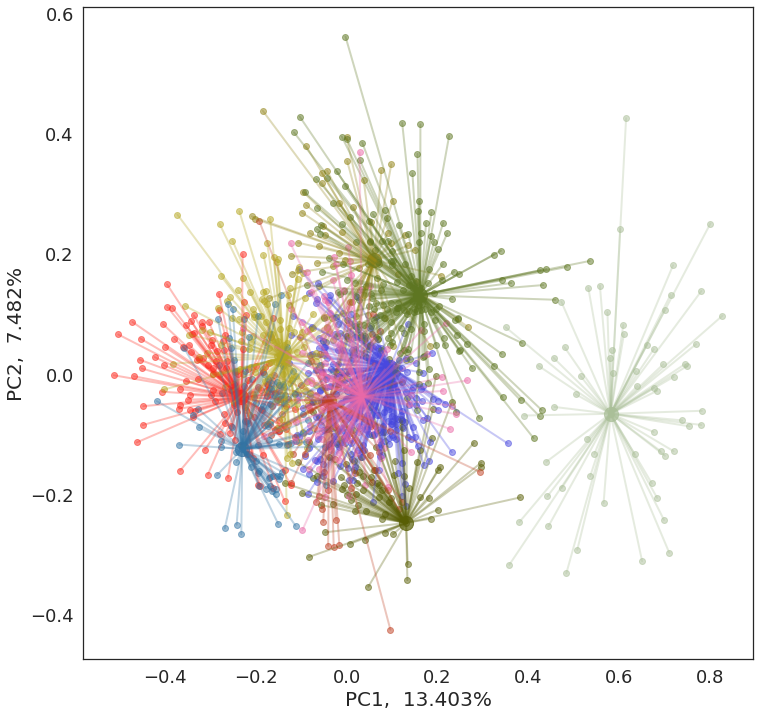

In [77]:
fig, ax = plt.subplots(figsize=(12,12))

plot_af_cluster(train_pcs[:, 0], train_pcs[:, 2], site_labels, cluster_centers, ax=ax)

ax.set_xlabel(f'PC1, {train_pcs_var[0] * 100: .3f}%')
ax.set_ylabel(f'PC2, {train_pcs_var[1] * 100: .3f}%')
plt.show()

### Cluster EPMs 

In [78]:
def fit_epm(values, ages) -> Tuple[EpigeneticPacemaker, np.ndarray]:
    epm = EpigeneticPacemakerCV(cv_folds=10)
    epm.fit(values, ages)
    states = epm.predict(values)
    return epm, states

In [79]:
def poly_fit(ages, states, degree=2):
    return np.polyfit(np.array(ages), np.array(states), degree)

In [80]:
def poly_predict_states(ages, poly):
    p = np.poly1d(poly)
    return p(ages)

In [81]:
epm = EpigeneticPacemakerCV(cv_folds=10)
epm.fit(epm_matrix.values, train_ages)
epm_states = epm.predict(epm_matrix.values)
epm_popt, _, expected_states = fit_trend(train_ages, epm_states)
epm_r2 = r2(epm_states, expected_states)
epm_mae = mae(epm_states, expected_states)
epm_poly = poly_fit(train_ages, epm_states)
epm_poly_expected = poly_predict_states(train_ages, epm_poly)

In [82]:
len(epm_states)

339

In [83]:
print(epm_r2, epm_mae)

0.6732367810762913 6.851238666576292


In [84]:
def plot_age_state_trends(summaries, ax, r2_filter=None):
    age_range = np.linspace(0,100, 100)
    for summary in summaries.values():
        if r2_filter:
            if summary['poly_r2'] < r2_filter:
                continue
        expected_range = poly_predict_states(age_range, summary['cluster_poly'])
        ax.plot(age_range, expected_range, 'k--', lw=2)
    return ax

In [85]:
def plot_epm(cluster_epm_info, cluster_epm_stats, ax, cluster_label='', cluster_hue=None, cluster_style=None, ages=None, states=None):
    clust_r2 = r2(basic_func(ages, *cluster_epm_info['popt']), states)
    fit_label = f'{cluster_label}  $f(x) = {cluster_epm_info["popt"][0]: .3f}x^{{0.5}} {cluster_epm_info["popt"][2]: .3f}, R^2={clust_r2: .3f}$'
    sns.scatterplot(x=ages, y=states, ax=ax, hue=cluster_hue, style=cluster_style)
    age_range = np.linspace(min(ages), max(ages), 100)
    expected_range = basic_func(age_range, *cluster_epm_info['popt'])
    ax.plot(age_range, expected_range, 'k--', lw=2, label=fit_label)
    ax.legend(fontsize=18, loc='upper left', frameon=False)
    ax.set_xlabel('Chronological Age (y)')
    ax.set_ylabel('State')
    return ax

In [86]:
cluster_epms = {}

for cluster, cluster_sites in tqdm(site_labels.items()):
    if len(cluster_sites) < 10:
        continue
    cluster_epm, cluster_states = fit_epm(epm_matrix.values[cluster_sites,:], train_ages)
    cluster_popt, _, expected = fit_trend(train_ages, cluster_states, func=basic_func)
    cluster_poly = poly_fit(train_ages, cluster_states, degree=2)
    cluster_poly_expected = poly_predict_states(train_ages, cluster_poly)
    cluster_epms[cluster] = dict(epm=cluster_epm, states=cluster_states, 
                                 expected_states=expected, popt=cluster_popt,
                                 r2=r2(cluster_states, expected),
                                 mae=mae(cluster_states, expected),
                                 cluster_size=len(cluster_sites),
                                 cluster_poly=cluster_poly, cluster_poly_expected=cluster_poly_expected,
                                 poly_r2=r2(cluster_states, cluster_poly_expected),
                                 poly_mae=mae(cluster_states, cluster_poly_expected))

  0%|          | 0/10 [00:00<?, ?it/s]

In [87]:
len(cluster_epms)

10

In [88]:
def get_cell_type_corr(states, cell_estimates, label=''):
    cell_corrs = {}
    for cell_type in list(cell_estimates):
        cell_corrs[f'{label}{cell_type}'] = stats.pearsonr(states, cell_estimates[cell_type].values)[0]
    return cell_corrs

In [89]:
cluster_count = 0

cluster_summaries_raw = {}

for cluster, cluster_info in cluster_epms.items():
    cluster_count += 1
    cluster_summary = dict(R2=cluster_info['r2'], MAE=cluster_info['mae'], ClusterSize=len(site_labels[cluster]),
                           StateSexCorr=stats.pearsonr(cluster_info['states'], train_sex)[0],
                           StateSexDiffCorr=stats.pearsonr(cluster_info['states'] - cluster_info['expected_states'], train_sex)[0],
                           StateAgeCorr=stats.pearsonr(cluster_info['states'], train_ages)[0])
    cluster_summary.update(get_cell_type_corr(cluster_info['states'], train_cells))
    cluster_summary.update(get_cell_type_corr(cluster_info['states'] - cluster_info['expected_states'], train_cells, 'diff_'))
    center_x, center_y = train_pcs[:,0][cluster_centers[cluster]], train_pcs[:,1][cluster_centers[cluster]]
    cluster_summary.update(dict(center_x=center_x, center_y=center_y))
    cluster_summaries_raw[cluster] = cluster_summary

In [90]:
cluster_summaries = pd.DataFrame(cluster_summaries_raw).T

In [91]:
cluster_summaries['AbsStateSexCorr'] = abs(cluster_summaries['StateSexCorr'])

In [92]:
cluster_summaries

,R2,MAE,ClusterSize,StateSexCorr,StateSexDiffCorr,StateAgeCorr,proc_CD8T,proc_CD4T,proc_NK,proc_Bcell,...,diff_proc_CD8T,diff_proc_CD4T,diff_proc_NK,diff_proc_Bcell,diff_proc_Mono,diff_proc_Gran,diff_Age,center_x,center_y,AbsStateSexCorr
2,0.833206,4.376799,250.0,-0.364119,-0.236140,0.914111,-0.380866,-0.348789,0.337588,-0.062177,...,-0.083568,-0.334260,0.230124,0.027944,0.174546,0.045067,0.008217,0.095696,0.120656,0.364119
8,0.192426,12.371399,137.0,-0.094165,0.038361,0.440352,-0.158773,-0.241221,0.119916,-0.019446,...,0.008744,-0.154908,0.003167,0.017714,0.114617,0.148544,0.002972,0.035245,-0.097462,0.094165
4,0.053933,17.813081,126.0,-0.017604,0.051918,0.232248,0.066213,0.491127,0.033405,-0.009655,...,0.158770,0.560457,-0.029376,0.009323,-0.009950,-0.404534,0.000548,-0.231639,0.111924,0.017604
3,0.774348,4.739022,68.0,-0.294251,-0.076206,0.883497,-0.393642,-0.385876,0.289574,-0.073978,...,-0.124997,-0.381526,0.115215,-0.006391,0.143217,0.209144,0.011576,-0.038150,0.209907,0.294251
9,0.025079,20.862412,63.0,-0.159168,-0.114169,0.162852,-0.452073,-0.352183,-0.193924,-0.675088,...,-0.396926,-0.319385,-0.239206,-0.670785,-0.089760,0.506846,0.004905,0.580465,0.141494,0.159168
6,0.754125,5.380130,196.0,-0.389036,-0.270999,0.872548,-0.390067,-0.407843,0.389155,-0.064239,...,-0.121397,-0.415223,0.317427,0.011638,0.233955,0.117083,0.012283,0.161896,0.120532,0.389036
5,0.154094,14.381203,147.0,-0.170635,-0.060366,0.395606,-0.230125,0.116944,-0.104012,0.070293,...,-0.088082,0.226405,-0.226994,0.110837,0.137060,-0.045525,0.004282,-0.138117,0.090484,0.170635
0,0.041961,15.180716,68.0,0.060621,0.123306,0.210612,-0.119397,-0.221158,-0.021505,-0.101787,...,-0.042487,-0.177280,-0.077823,-0.087120,0.012633,0.222175,0.006363,0.060071,-0.068758,0.060621
7,0.124020,13.037944,92.0,-0.004955,0.105046,0.356952,-0.279731,-0.353108,-0.071841,-0.272374,...,-0.155948,-0.289775,-0.177176,-0.260683,0.211059,0.382747,0.005958,-0.229688,-0.055509,0.004955
1,0.045495,17.304633,83.0,-0.140460,-0.079746,0.221030,-0.347668,-0.412163,-0.083106,-0.156821,...,-0.272926,-0.371100,-0.143328,-0.142914,0.063022,0.336931,0.008405,0.130743,-0.109529,0.140460


In [93]:
test_clusters = list(cluster_summaries.loc[cluster_summaries['MAE'] < 6].index)

In [94]:
combined_clust_sites = np.array(sum([site_labels[clust] for clust in test_clusters], []))

In [95]:
len(combined_clust_sites)

514

In [96]:
combined_epm, combined_train_states = fit_epm(epm_matrix.values[combined_clust_sites,:], train_ages)
combined_popt, _, combined_train_expected_states = fit_trend(train_ages, combined_train_states)
combined_r2 = r2(combined_train_states, combined_train_expected_states)
combined_mae = mae(combined_train_states, combined_train_expected_states)

In [97]:
combined_info = {'popt':combined_popt}

### Load Test Data

In [98]:
test_files = [get_sample_matrix_info(cs_meta[sample]) for sample in test_samples]
test_files = {sample[0]: f'{processing_dir}{sample[1]}_methmatrix.gz' for sample in test_files}

In [99]:
test_row_labels = list(set(lm_labels + epm_sites))

In [100]:
test_methylation, test_header, test_rows = retrieve_sample_methylation(test_files, n_jobs=16, 
                                                                       verbosity=10, rows=test_row_labels)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of   5 | elapsed:   43.1s remaining:  1.1min
[Parallel(n_jobs=16)]: Done   3 out of   5 | elapsed:   43.9s remaining:   29.3s
[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:   45.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:   45.0s finished


In [101]:
cleaned_test_header = [x.replace('"', '').split('_')[0] for x in test_header][1:]

In [102]:
test_matrix = pd.DataFrame(test_methylation, columns = cleaned_test_header, index=test_rows)
test_lm_matrix = test_matrix.loc[lm_labels]
test_epm_matrix = test_matrix.loc[epm_matrix.index]

### Test predictions 

In [103]:
test_ages = np.array([cs_meta[sample]['age yrs'] for sample in list(test_matrix)])

In [104]:
test_sex = np.array([cs_meta[sample]['proc_predictedSex'] for sample in list(test_matrix)])
test_sex = np.array([1 if sex == 'F' else 0 for sex in test_sex])

In [105]:
test_cells = []

for ct in cell_types:
    test_cells.append([cs_meta[sample][ct] for sample in list(test_matrix)])

In [106]:
test_cells = pd.DataFrame(test_cells, columns=list(test_matrix), index=cell_types).T

In [107]:
test_predictions = {}

for clust_label, clust in cluster_epms.items():
    cluster_sites = site_labels[clust_label]
    epm_states = clust['epm'].predict(epm_matrix.values[cluster_sites,:])
    test_predictions[clust_label] = dict(epm_states=epm_states)

In [108]:
combined_test_states = combined_epm.predict(test_epm_matrix.values[combined_clust_sites])

In [109]:
test_full_lm_predictions = get_sparse_model_predictions(test_matrix.loc[lm_labels].values, sparse_full_lm) 

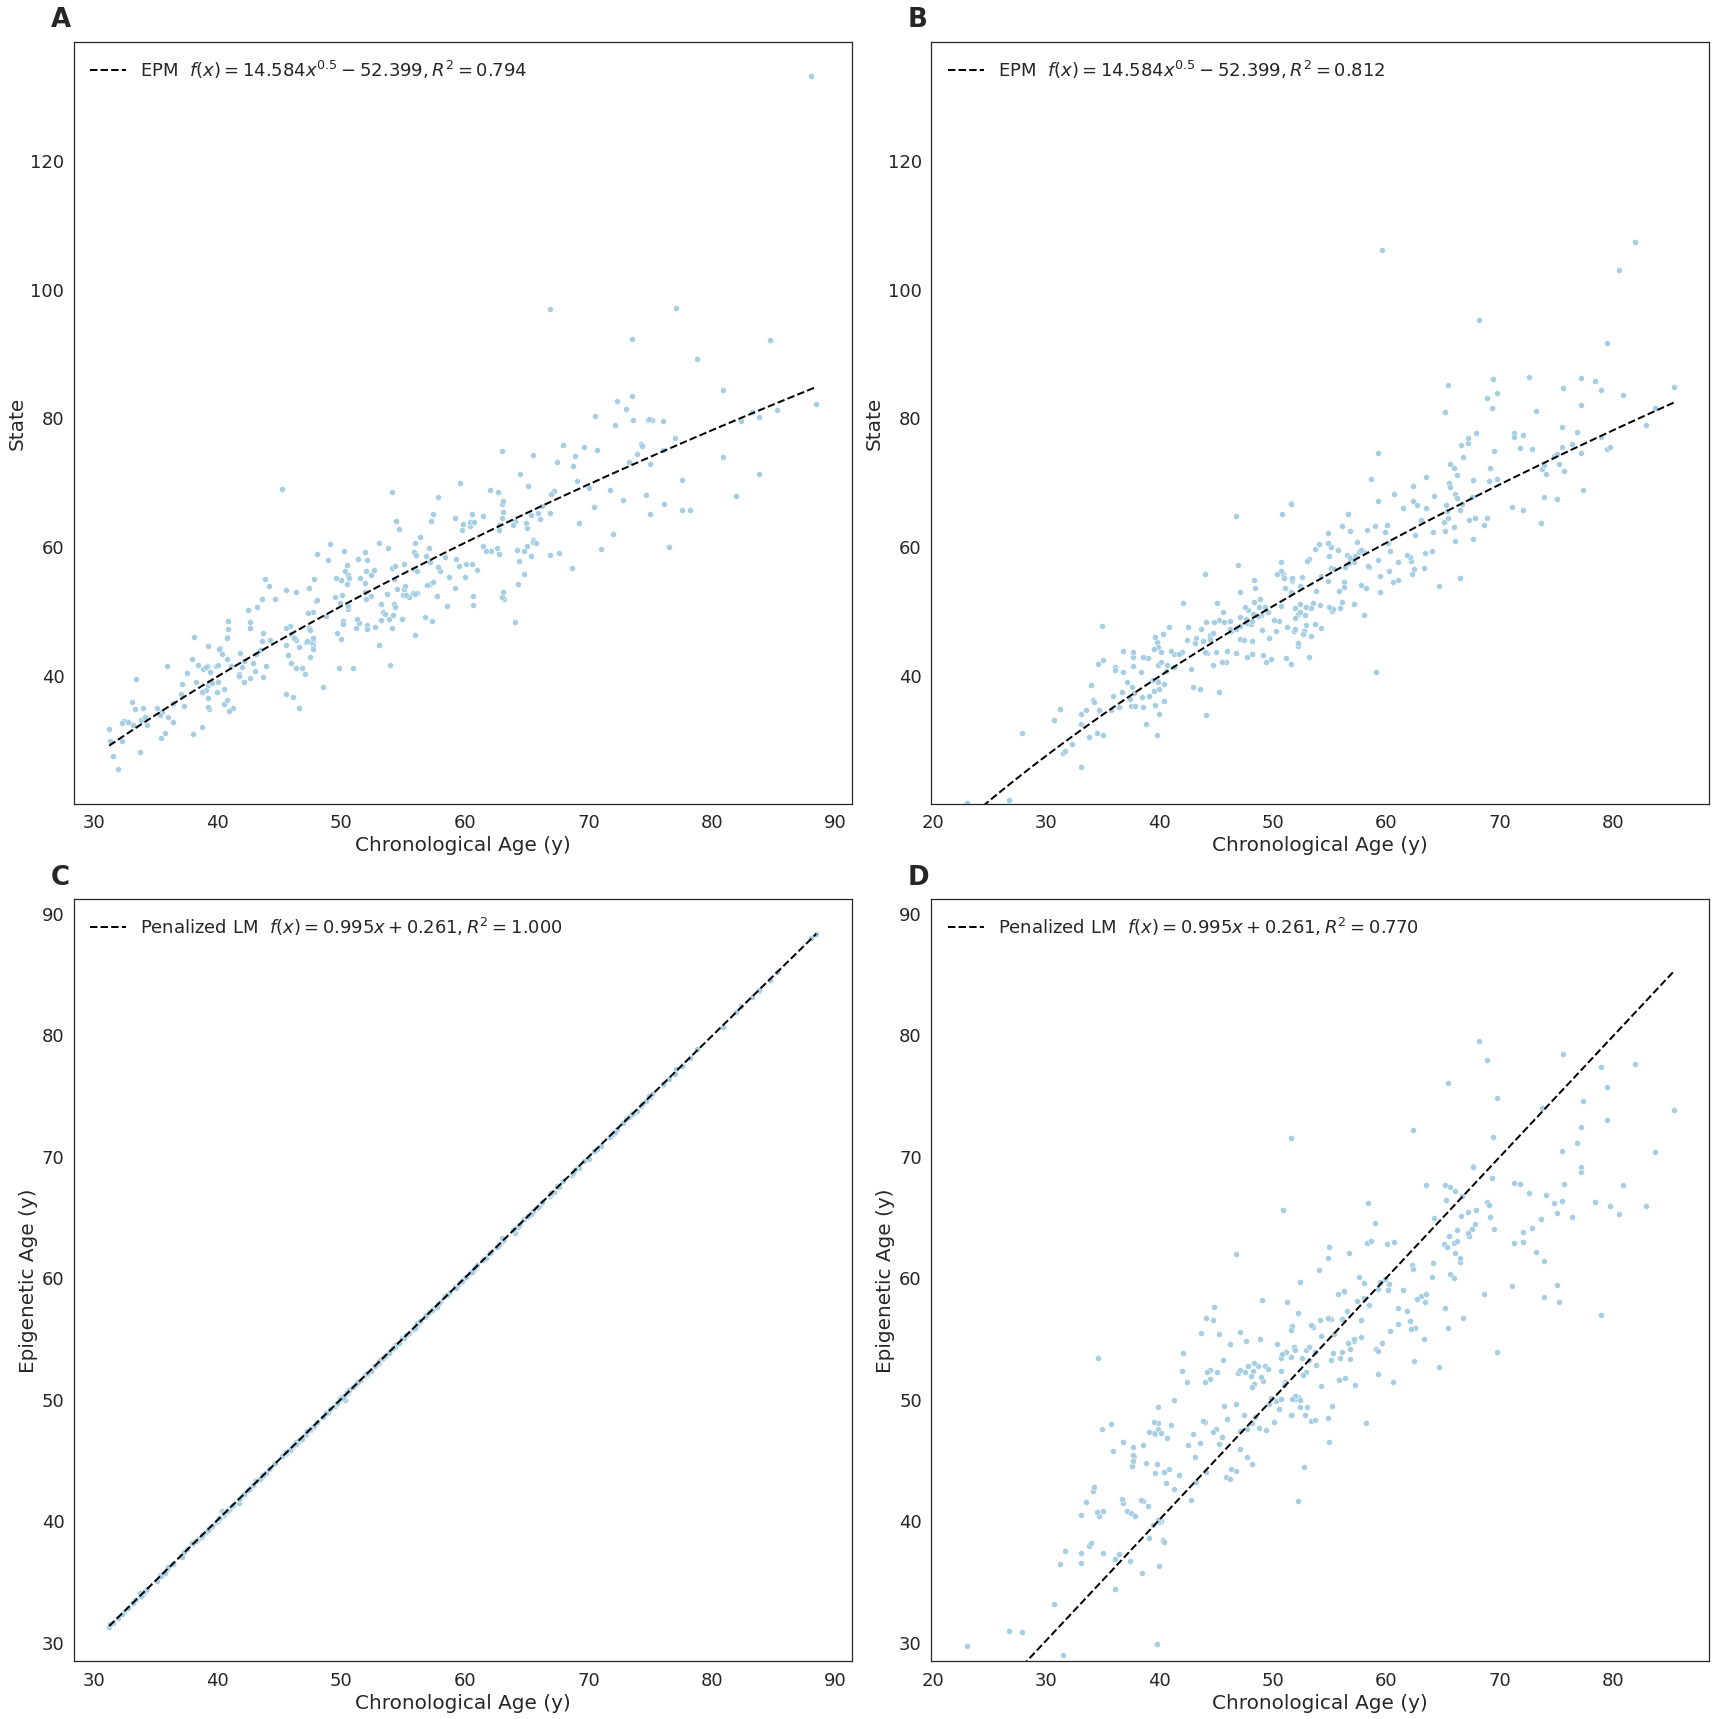

In [110]:
fig, ax = plt.subplots(2,2, figsize=(24,24))

plot_epm(combined_info, {}, ax[0,0], cluster_label='EPM', ages=train_ages, states=combined_train_states)
ax[0,1].set_ylim(ax[0,0].get_ylim())
plot_epm(combined_info, {}, ax[0,1], cluster_label='EPM', ages=test_ages, states=combined_test_states)


plot_lm(full_lm_popt, ax[1, 0], label='Penalized LM', ages=train_ages, eas=train_lm_predictions)
ax[1,1].set_ylim(ax[1,0].get_ylim())
plot_lm(full_lm_popt, ax[1, 1], label='Penalized LM', ages=test_ages, eas=test_full_lm_predictions)

ax[0,0].text(-0.03, 1.02, f'A', transform=ax[0,0].transAxes, fontsize=26, weight='bold')
ax[0,1].text(-0.03, 1.02, f'B', transform=ax[0,1].transAxes, fontsize=26, weight='bold')

ax[1,0].text(-0.03, 1.02, f'C', transform=ax[1,0].transAxes, fontsize=26, weight='bold')
ax[1,1].text(-0.03, 1.02, f'D', transform=ax[1,1].transAxes, fontsize=26, weight='bold')



plt.tight_layout()
plt.savefig('figures/S.Figure2.png', dpi=300)

plt.show()

### Check for Phenotype Associations 

In [111]:
def get_exp_phenotypes(meta_data, states, samples, expected):
    exp_df = pd.DataFrame({sample:meta_data[sample] for sample in samples}).T
    exp_df['States'] = states
    exp_df['Diff'] = states - expected
    exp_df['AgeYrs'] = exp_df['age yrs'].values
    exp_df['SqrtAge'] = np.sqrt(exp_df['AgeYrs'].values.astype('float'))
    exp_df['ProcSex'] = [0 if sex == 'M' else 1 for sex in exp_df['proc_predictedSex'].values]
    exp_df['AgeSex'] = exp_df['age yrs'] * exp_df['ProcSex']
    exp_cell_pcs = cell_pca.transform(exp_df[cell_types].values)
    for col in range(exp_cell_pcs.shape[1]):
        exp_df[f'PC{col + 1}'] = exp_cell_pcs[:,col]
    return exp_df

In [112]:
def get_design_matrices(y_cat=None, x_cats=[], exp_df=None, fit_intercept=False):
    intercept = ' + 0' if not fit_intercept else ''
    r_df = exp_df[[y_cat] + x_cats]
    r_df = r_df.replace('NA', np.nan)
    r_df = r_df.dropna(axis=0)
    r_df = r_df.astype('float')
    xs = ' + '.join(x_cats)
    y, X = dmatrices(f'{y_cat} ~ {xs}{intercept}', data=r_df, return_type='dataframe')
    return y, X

In [113]:
def fit_exp_model(y_cat=None, x_cats=None, states=None, samples=None, meta_data=None, expected=None, fit_intercept=False):
    exp_df = get_exp_phenotypes(meta_data, states, samples, expected)
    y, X = get_design_matrices(y_cat, x_cats, exp_df, fit_intercept=fit_intercept)
    results = sm.OLS(y, X).fit()
    return results

In [114]:
def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        return value

In [115]:
def format_res(res, exp, model_type, sex_dist):
    model_info = {'ExperimentID':exp, 'ModelType':model_type,
                  'SexDist':sex_dist} 
    for key, value in res.summary2().tables[1].T.to_dict().items():
        for cat in ['Coef.', 'Std.Err.', 't', 'P>|t|']:
            model_info[f'{key} {cat}'] = value[cat]
    for table in [0, 2]:
        for x in res.summary2().tables[table].values:
            for y in range(int(len(x) / 2)):
                model_info[x[y * 2]] = convert_to_float(x[y * 2 + 1])
    return model_info

In [116]:
x_cats = ['AgeYrs', 'ProcSex',
    'PC1',
 'PC2',
 'PC3',
 'SqrtAge', 
  'pbb_153']

In [117]:
cs_meta = dict(cs_meta)

In [118]:
for key, value in cs_meta.items():
    try:
        value['pbb_153'] = float(value['pbb-153'])
    except ValueError:
        value['pbb_153'] = np.nan

In [119]:
all_res = {}

for exp in tqdm(case_study_exp):
    _samples = [sample for sample in list(test_matrix) if cs_meta[sample]['experiment_id'] == exp]
    if not _samples:
        continue
    _ages = np.array([cs_meta[sample]['age yrs'] for sample in list(test_matrix) if cs_meta[sample]['experiment_id'] == exp])
    _states = [state for state, sample in zip(combined_test_states, list(test_matrix)) if cs_meta[sample]['experiment_id'] == exp]
    _expected = basic_func(_ages, *combined_popt)
    _full_eas = np.array([state for state, sample in zip(test_full_lm_predictions, list(test_matrix)) if cs_meta[sample]['experiment_id'] == exp])
    # fit sm OLS
    _sex = np.array([0 if cs_meta[sample]['proc_predictedSex'] == 'M' else 1 for sample in list(test_matrix) if cs_meta[sample]['experiment_id'] == exp])
    _sex_dist = sum(_sex) / len(_sex)
    fit_cats = x_cats
    if _sex_dist > .7:
        fit_cats = [cat for cat in x_cats if cat != 'ProcSex']
    _state_res = fit_exp_model(y_cat='States', x_cats=fit_cats, states=_states, samples=_samples, 
                               meta_data=cs_meta, expected=_expected, fit_intercept=True)
    _full_ea_res = fit_exp_model(y_cat='States', x_cats=fit_cats, states=_full_eas, samples=_samples, 
                                 meta_data=cs_meta, expected=_ages, fit_intercept=True)
    all_res[f'{exp}_epm'] = format_res(_state_res, exp, 'epm', _sex_dist)
    all_res[f'{exp}_full_lm'] = format_res(_full_ea_res, exp, 'flm', _sex_dist)

  0%|          | 0/1 [00:00<?, ?it/s]

In [120]:
model_df = pd.DataFrame(all_res).T

In [121]:
#model_df['ln_totalpbb P>|t|']
model_df['pbb_153 P>|t|']

GSE116339_epm             0.0
GSE116339_full_lm    0.141213
Name: pbb_153 P>|t|, dtype: object

In [122]:
p_val_cats = [f'{cat} P>|t|' for cat in x_cats] 
coef_cats = [f'{cat} Coef' for cat in x_cats]

plot_cats = ['ExperimentID', 'ModelType']

In [123]:
single_var_values = [] 

for cat in x_cats:
    for site_type in ['P>|t|', 'Coef.']:
        p_df = model_df[['ExperimentID', 'ModelType', f'{cat} {site_type}']].copy()
        p_df['cat'] = np.array([cat for _ in range(p_df.shape[0])])
        p_df['SiteType'] = [site_type for _ in range(p_df.shape[0])]
        single_var_values.extend(p_df.values)

In [124]:
reg_var_df = pd.DataFrame(single_var_values, columns=['ExperimentID', 'ModelType', 'Value', 'Category', 'ValueType'])

In [125]:
for model in ['epm', 'flm']:
    _model_df = reg_var_df.loc[reg_var_df['ModelType'] == model].loc[reg_var_df['Category'] == 'ProcSex'].loc[reg_var_df['ValueType'] == 'P>|t|']
    print(np.nanmean(_model_df['Value'].values), np.nanmedian(_model_df['Value'].values), 
          len([x for x in _model_df['Value'].values if not np.isnan(x)]), len([x for x in _model_df['Value'].values if not np.isnan(x) and x < 0.05 / 3]))

1.1241085172147113e-06 1.1241085172147113e-06 1 1
0.028311628279868797 0.028311628279868797 1 0
